In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanIoU

import segmentation_utils as su

CLASSES = {0 : 'background',
           5 : 'Mucosa',
           4 : 'Linfocitos',
           1 : 'Submucosa',
           3 : 'Muscular',
           2 : 'Subserosa',
          }
NUM_CLASSES = len(CLASSES)

TRAIN_PATH = './database/'
IMG_SIZE = 512    # must be divisible by 32
BATCH_SIZE = 32
SEED = 123
BACKBONE = 'resnet34'
backbone_preprocess = sm.get_preprocessing(BACKBONE)
scaler = MinMaxScaler()

2021-08-05 11:26:14.254928: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


# Load data

In [2]:
def preprocess_data(img, mask):
    global NUM_CLASSES
    #img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = backbone_preprocess(img)

    #Encode labels from 0 to NUM_CLASSES
    labelencoder = LabelEncoder()
    #Must be transformed to 1 dim array
    n, h, w, c = mask.shape
    mask = mask.reshape(-1,1)
    #transform colours into labels
    mask = labelencoder.fit_transform(mask)
    mask = mask.reshape(n, h, w)
    #Transform 1 channel label to hot encoded
    mask = tf.keras.utils.to_categorical(mask, NUM_CLASSES)

    return (img, mask)

def get_segmentation_generator(path, mode, augmentation=True, val_split=0.2):
    """
    Returns a generator for both input images and masks.
    Must have defined a preprocess_data(img, mask) function returning (img, mask)
    :param path: path to the target dir containing images and masks directories
    :mode: spicify whether is training or validation split
    :augmentation: boolean for performing data augmentation (default=True)
    :val_split: the validation split (default=0.2)
    :return: generator
    """ 
    if(augmentation):
        data_gen_args = dict(validation_split=val_split,
                             horizontal_flip=True,
                             vertical_flip=True,
                             #rotation_range=90.,
                             #width_shift_range=0.1,
                             #height_shift_range=0.1,
                             #zoom_range=0.2,
                             #shear_range=0.05,
                             #brightness_range=None,
                             fill_mode='reflect', #'constant','nearest','reflect','wrap'
                             #dtype=None,
                             #featurewise_center=True,
                             #featurewise_std_normalization=True,
                             rescale=1. / 255,  #input normalizatoin
                            ) # Mejor manera: DigitalSreeni 216 min 19
   
    else: data_gen_args = dict(validation_split=val_split,
                               rescale=1. / 255
                              )

    # same arguments in order to transform images and masks equaly
    image_datagen = ImageDataGenerator(**data_gen_args)    
    
    image_generator = image_datagen.flow_from_directory(
        directory=path+'images',
        #shuffle=True,
        subset=mode,  # train or validation
        class_mode=None,
        seed=SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    mask_generator = image_datagen.flow_from_directory(
        directory=path+'masks',
        color_mode='grayscale',
        #shuffle=True,
        subset=mode,  # train or validation
        class_mode=None,
        seed=SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    
    generator = zip(image_generator, mask_generator)
    for (img, mask) in generator:
        img, mask = preprocess_data(img, mask)
        yield (img, mask)
        
        
train_generator = get_segmentation_generator(TRAIN_PATH, mode='training', augmentation=True)
# validation data should never be augmented
val_generator = get_segmentation_generator(TRAIN_PATH, mode='validation', augmentation=False)

# Check loaded images

Found 38 images belonging to 1 classes.
Found 38 images belonging to 1 classes.


/mnt/beegfs/spack/opt/spack/linux-centos7-x86_64/gcc-4.9.4/miniconda3-4.3.30-rc2pkggawlbh6twcvefw6pwv7sgc6bc5/envs/tensorflow_2.5/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Found 9 images belonging to 1 classes.
Found 9 images belonging to 1 classes.
Images is shape (32, 512, 512, 3)
Masks is shape (32, 512, 512, 6) and has values [0. 1.]


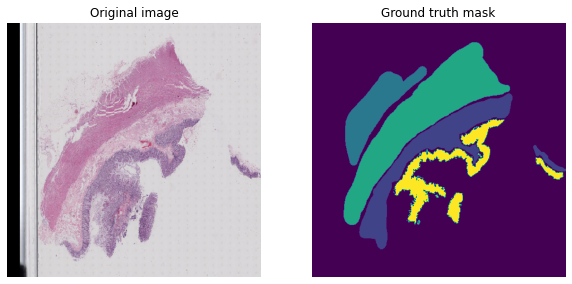

In [3]:
images, masks = train_generator.__next__()
val_images, val_masks = val_generator.__next__()

#print('Detected', len(images), 'images for training and', len(val_images), 'images for validation')
print('Images is shape', images.shape)
print('Masks is shape', masks.shape, 'and has values', np.unique(masks))

one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
su.plot_mask(images, one_channel_masks)

# Prepare U-net model

In [ ]:
sm.set_framework('tf.keras')
sm.framework()

ACTIVATION = 'softmax'
OPTIMIZER = tf.keras.optimizers.Adam(0.0001)

#class_weights = [0.2138, 2.6031, 2.9286, 2.5219, 69.9673, 5.3551]
#class_weights = [0.2177, 2.6855, 2.8543, 2.3903, 109.975, 3.9136]
class_weights = su.get_class_weights(TRAIN_PATH+'masks/img')
print('Class weights:', class_weights)

dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
TOTAL_LOSS = dice_loss + (1 * focal_loss)


METRICS = metrics = [sm.metrics.IOUScore(threshold=0.5),
                     sm.metrics.FScore(threshold=0.5)]

model = sm.Unet(BACKBONE, 
                encoder_weights='imagenet',
                classes=NUM_CLASSES, 
                activation=ACTIVATION,
                #encoder_freeze=True
               )

model.compile(OPTIMIZER, 
              loss=TOTAL_LOSS,
              metrics=METRICS)
#model.summary()    #print the model structure


# This class is used by model.fet to print a prediction at the end of every epoch
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        images, masks = train_generator.__next__()
        predictions = model.predict(images)
        one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
        one_channel_predictions = np.argmax(predictions, axis=3) #hot encoded to 1 channel
        su.plot_prediction(images, one_channel_masks, one_channel_predictions)

# Train the model


Sample Prediction after epoch 30



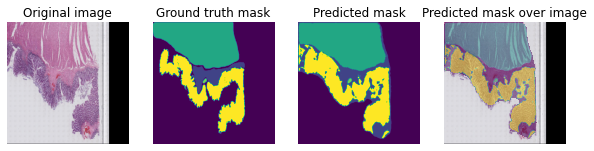

Epoch 31/50
 9/50 [====>.........................] - ETA: 44s - loss: -15.1584 - iou_score: 0.6811 - f1-score: 0.7842

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=50,
                    validation_data=val_generator,
                    validation_steps=50,
                    callbacks=[DisplayCallback()]
                   )

model.save('./resources/unet_first_working.hdf5')

# Evaluate the results

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'history_unet_50epochs.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

max_iou = max(val_acc)
print ("Maximum accuracy reached: ", max_iou)
max_index = val_acc.index(max_iou)
print("Maximum accuracy reached at epoch: ",max_index+1)

In [ ]:
#model = load_model('./sources/xxxxxxxxxxxx.hdf5', compile=False)

test_images, test_masks = val_generator.__next__()
prediction=model.predict(test_images)

test_masks = np.argmax(test_masks, axis=3) #from hot encoded to 1 channel
prediction=np.argmax(prediction, axis=3)

IOU = MeanIoU(num_classes=NUM_CLASSES)  
#compare groun truth and predicted masks
IOU.update_state(test_masks, prediction)

#calculate I0U for each class...
values = np.array(IOU.get_weights()).reshape(NUM_CLASSES, NUM_CLASSES)

#IoU = true positive / (true positive +
#                       false poitives (same row) +
#                       false negatives (same column))
class0_IoU = values[0,0] / (values[0,0] +
                            values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] +
                            values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0])

class1_IoU = values[1,1] / (values[1,1] +
                            values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] +
                            values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1])

class2_IoU = values[2,2] / (values[2,2] +
                            values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] +
                            values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2])

class3_IoU = values[3,3] / (values[3,3] +
                            values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] +
                            values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3])

class4_IoU = values[4,4] / (values[4,4] +
                            values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] +
                            values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4])

class5_IoU = values[5,5] / (values[5,5] +
                            values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] +
                            values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5])


print("Mean IoU using Unet =", IOU.result().numpy())
print('IoU for',CLASSES[0],'is:', class0_IoU)
print('IoU for',CLASSES[1],'is:', class1_IoU)
print('IoU for',CLASSES[2],'is:', class2_IoU)
print('IoU for',CLASSES[3],'is:', class3_IoU)
print('IoU for',CLASSES[4],'is:', class4_IoU)
print('IoU for',CLASSES[5],'is:', class5_IoU)
with np.printoptions(suppress=True):
    print('\n', values)

#with np.printoptions(threshold=np.inf):
#    print(test_masks[0])

su.plot_prediction(test_images, test_masks, prediction)